In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 
import os,sys,json

In [ ]:
!nvidia-smi

Mon Oct 18 08:21:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import cv2
!pip install --upgrade albumentations
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/AI-C/path7-completed.zi -d data_dir

In [ ]:
PATH = './data_dir/path7'
paths = os.listdir(PATH)
path_image = [os.path.join(PATH,i) for i in paths if 'mask' not in i]


In [ ]:
path_mask = [os.path.join(PATH,i[:-4] + "_color_mask.png") for i in paths if 'mask' not in i]

In [ ]:
# path_mask
# path_mask

In [ ]:
# path_image
# cv2.imread(path_mask[0])
mask = cv2.imread(path_mask[0],cv2.COLOR_BGR2GRAY)[...,1]
mask = (255-mask) 
# mask = (mask > 0).astype('float')
# mask = np.where(mask > 0., 0., 1.)
mask = np.where(mask > 255/2,1,0)

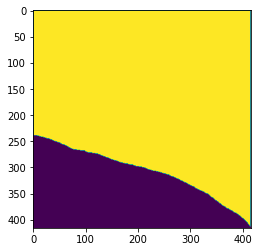

In [ ]:
plt.imshow(mask)

In [ ]:
import albumentations as A
import albumentations.augmentations.functional as FA
# from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm


train_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
        A.RandomBrightnessContrast(p=0.4),
        
    ]
)

val_transform = A.Compose(
    [
        A.PadIfNeeded(min_height=256, min_width=256),
        A.CenterCrop(256, 256),
    ]
)
# A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),


def get_preprocessing(preprocessing_fn):

    
    _transform = [
        A.Lambda(image=preprocessing_fn),
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)


def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
# for i in range(2):
#     image, mask = train_data[i]
#     print(image.shape,mask.shape,train_data.list_img[i],train_data.get_file_mask(i))
#     visualize(image=image, mask=mask)

In [ ]:
# path_image

In [ ]:
import glob,cv2


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def preprocess_input(
    x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], input_space="RGB", input_range=[0,1], **kwargs
):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


class DataTrafic(object):
    img_end_with = ["png","jpg","pnm","jpeg"]
    def __init__(self, folder_dir:list=None, augmentation = None, preprocessing=None,classes = None):
        assert folder_dir is not None, "folder_dir should be provide"
        self.folder_dir =[i for i in folder_dir]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.classes = classes
        
        if self.classes is None:
            print("None classes set to default 0")
            self.classes = [0]
        

         
    
    def __len__(self):return len(self.folder_dir)
    
    def get_file_mask(self,index):

        return self.folder_dir[index][1]
       
    def __call__(self):
        idx = list(range(len(self)))
        np.random.shuffle(idx)
        for i in idx:
          yield self[i]
          
    def __getitem__(self,index):
        
        path = self.data[index]
        label = self.label[index]

        # load anh 
        image =cv2.imread(path)
    
        image = cv2.resize(img,[224,224])

        return image, label


In [ ]:
def test():
  for i in range(10):
    yield i

m = test()
m

<generator object test at 0x7f90696a19d0>

In [ ]:
for i in test():
  print(i)

0
1
2
3
4
5
6
7
8
9


1

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
image = np.random.randn(1000, 32, 32,3)
label = np.random.randn(1000,1)
def generator():
  while True:
    for i in range(1000):

      img = image[i]

      img = cv2.resize(img, (224,224))

      yield img, label[i]

dataset = tf.data.Dataset.from_generator(
    
     generator,

     output_signature=(
         
         tf.TensorSpec(shape=(224,224,3), dtype=tf.float32),
         tf.TensorSpec(shape=(1,), dtype=tf.float32))
     )

# list(dataset.take(1))



In [ ]:
for i in dataset.take(1):
  print(i)

In [ ]:
folder  = zip(path_image, path_mask)
train_data = DataTrafic(folder,augmentation=train_transform,preprocessing = get_preprocessing(preprocess_input))
# vali_data = DataTrafic("./data/drive-download-20201203T073237Z-001/",augmentation=val_transform,preprocessing=get_preprocessing(preprocess_input))

None classes set to default 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081545072636929.jpg ./data_dir/path7/16081545072636929_color_mask.png


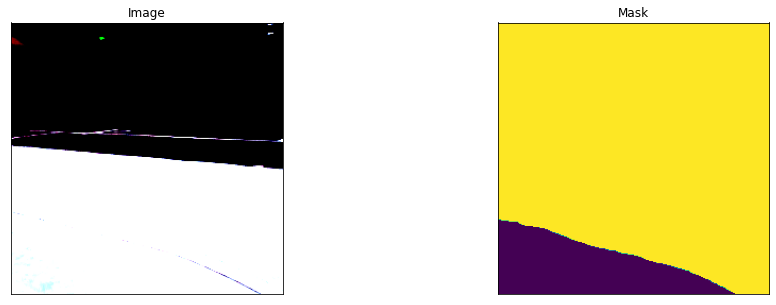

(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081544879816449.jpg ./data_dir/path7/16081544879816449_color_mask.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


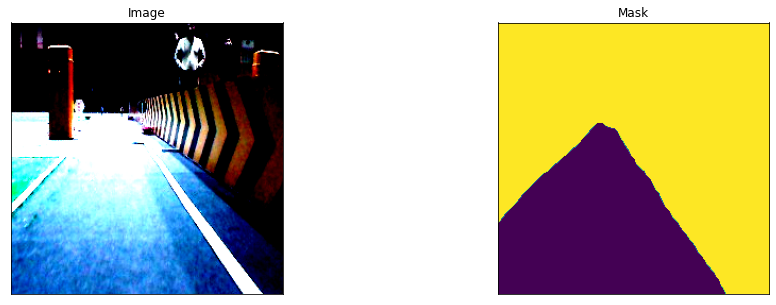

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081545039623659.jpg ./data_dir/path7/16081545039623659_color_mask.png


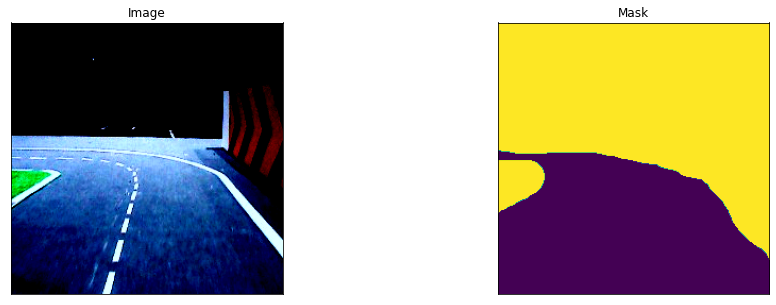

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081544783322504.jpg ./data_dir/path7/16081544783322504_color_mask.png


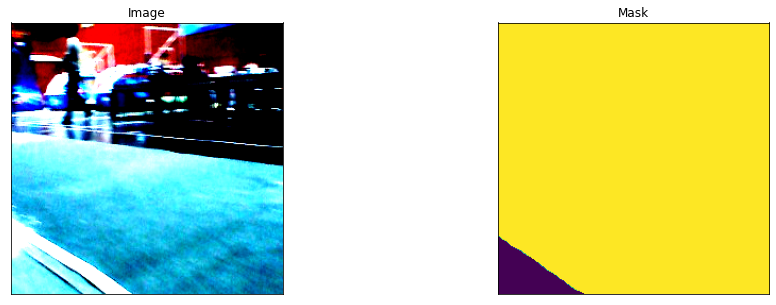

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/1608154493045244.jpg ./data_dir/path7/1608154493045244_color_mask.png


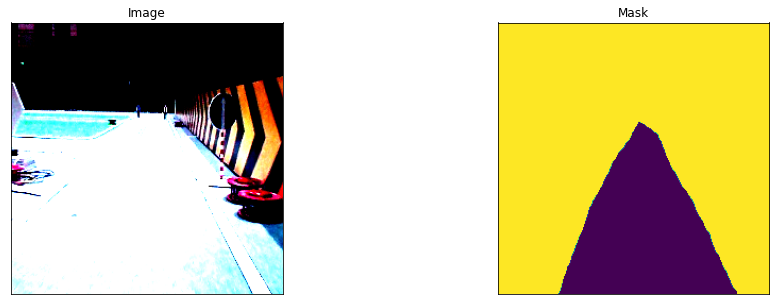

(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081544959379299.jpg ./data_dir/path7/16081544959379299_color_mask.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


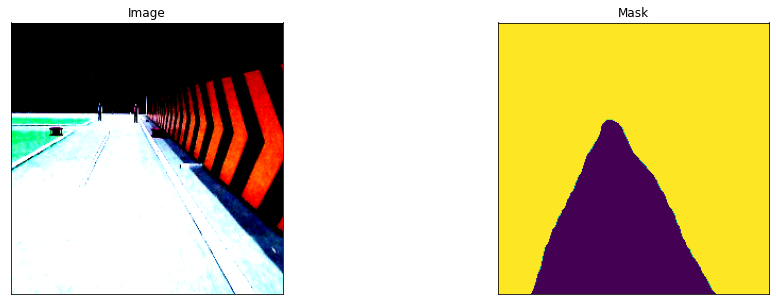

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081544750334702.jpg ./data_dir/path7/16081544750334702_color_mask.png


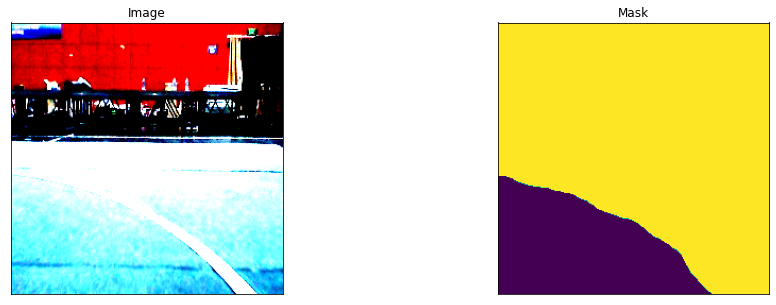

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/1608154500469049.jpg ./data_dir/path7/1608154500469049_color_mask.png


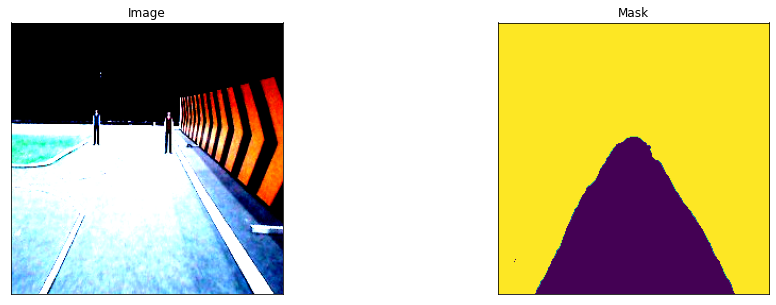

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081544910487056.jpg ./data_dir/path7/16081544910487056_color_mask.png


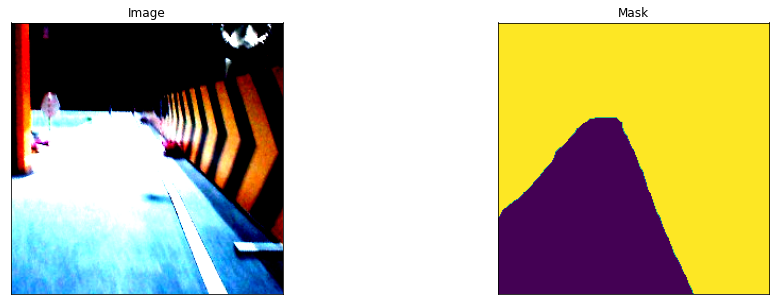

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3) (256, 256, 1) ./data_dir/path7/16081545105575912.jpg ./data_dir/path7/16081545105575912_color_mask.png


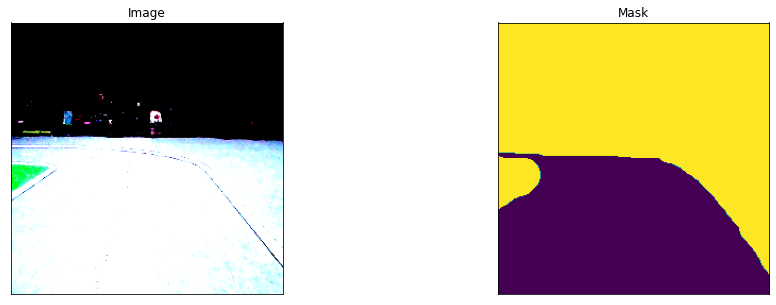

In [ ]:

for i in range(10):
    image, mask = train_data[i]
    print(image.shape,mask.shape,train_data.folder_dir[i][0],train_data.get_file_mask(i))
    visualize(image=image, mask=mask[...,0])

In [ ]:
dataset = tf.data.Dataset.from_generator(train_data, output_signature=(
    tf.TensorSpec(shape=(256,256,3), dtype=tf.float32), tf.TensorSpec(shape=(256,256,1), dtype=tf.float32))).prefetch(2) # 2CPU persample

In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,3), num_classes=1):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = tf.keras.layers.Conv2D(num_classes, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = [inputs], outputs = [conv10])

    from keras import backend as K
    def iou_coef(y_true, y_pred, smooth=1):
      intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
      union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
      iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
      return iou
    model.compile(optimizer = tf.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy',iou_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [ ]:
model = unet()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

In [ ]:
model.fit(
    dataset.batch(16).repeat(),
    steps_per_epoch=len(train_data) // 16,
    epochs=2,
    validation_data=dataset.batch(16).repeat(),
    validation_steps= 5, # test
)

Epoch 1/2
12/12 [==============================] - 34s 3s/step - loss: 0.6918 - accuracy: 0.7337 - iou_coef: 0.6531 - val_loss: 0.3670 - val_accuracy: 0.7463 - val_iou_coef: 0.7097
Epoch 2/2
12/12 [==============================] - 31s 3s/step - loss: 0.3133 - accuracy: 0.7625 - iou_coef: 0.7600 - val_loss: 0.2887 - val_accuracy: 0.7619 - val_iou_coef: 0.7589
